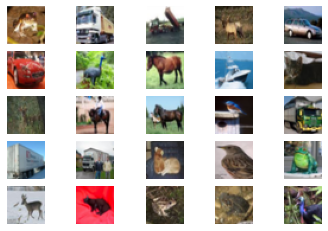

In [2]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
(trainX, trainy), (testX, testy) = load_data()

for i in range(25):
  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(trainX[i])
pyplot.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

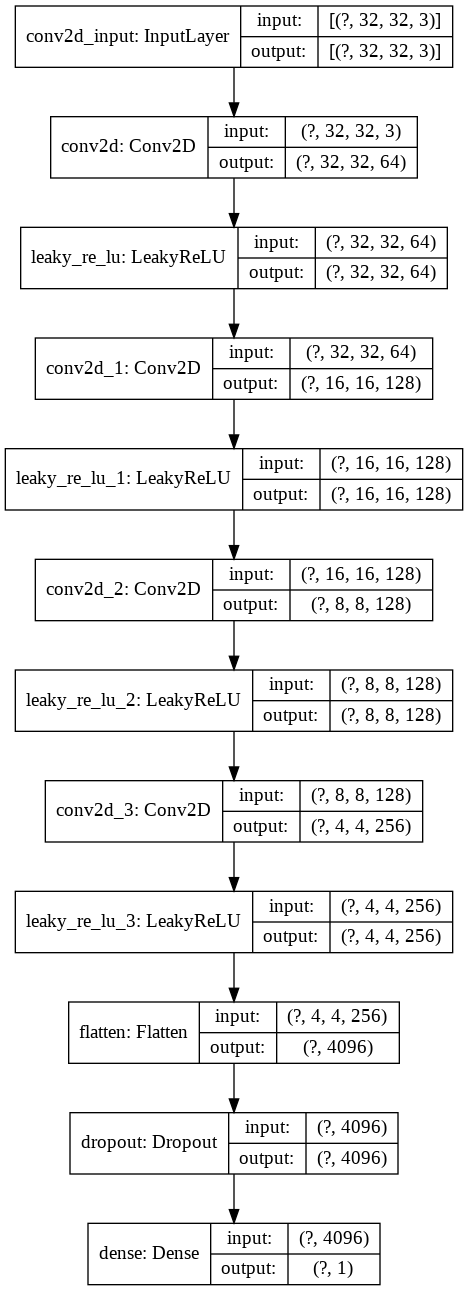

In [3]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
# load and prepare cifar10 training images
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  # convert from unsigned ints to floats
  X = trainX.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1)
  y = ones((n_samples, 1))
  return X, y

  
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples, 1))
  return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i])
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

In [5]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      # evaluate the model performance, sometimes
      if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
history = train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/390, d1=0.693, d2=0.696 g=0.691
>1, 2/390, d1=0.634, d2=0.698 g=0.689
>1, 3/390, d1=0.571, d2=0.705 g=0.682
>1, 4/390, d1=0.476, d2=0.726 g=0.664
>1, 5/390, d1=0.364, d2=0.771 g=0.628
>1, 6/390, d1=0.243, d2=0.866 g=0.577
>1, 7/390, d1=0.167, d2=0.973 g=0.549
>1, 8/390, d1=0.156, d2=0.991 g=0.575
>1, 9/390, d1=0.189, d2=0.898 g=0.656
>1, 10/390, d1=0.184, d2=0.766 g=0.788
>1, 11/390, d1=0.192, d2=0.620 g=0.993
>1, 12/390, d1=0.131, d2=0.488 g=1.206
>1, 13/390, d1=0.201, d2=0.486 g=1.187
>1, 14/390, d1=0.135, d2=0.526 g=1.058
>1, 15/390, d1=0.248, d2=0.594 g=0.886
>1, 16/390, d1=0.239, d2=0.649 g=0.805
>1, 17/390, d1=0.220, d2=0.669 g=0.771
>1, 18/390, d1=0.250, d2=0.701 g=0.748
>1, 19/390, d1=0.152, d2=0.757 g=0.727
>1, 20/390, d1=0.110, d2=0.906 g=0.668
>1, 21/390, d1=0.128, d2=1.232 g=0.577
>1, 22/390, d1=0.154, d2=1.535 g=0.545
>1, 23/390, d1=0.210, d2=1.304 g=0.699
>1, 24/390, d1=0.254, d2=0.797 g=1.059
>1, 25/390, d1=0.369, d2=0.475 g=1.387
>1, 26/390, d1=0.385, d2=0.396 g=1

In [12]:
model.save('/content/mnist_dense.h5')

In [ ]:
from keras.models import load_model

# load model
model = load_model('/content/mnist_dense.h5')
# generate images
latent_points = generate_latent_points(5, 5)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)